In [1]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.colors
import dash
import squarify
from dash import dcc, html
import numpy as np
from dash.dependencies import Input, Output
pio.templates.default = "plotly_white"

In [2]:
data = pd.read_csv("rfm_data.csv")
print(data.head())

   CustomerID PurchaseDate  TransactionAmount ProductInformation  OrderID  \
0        8814   2023-04-11             943.31          Product C   890075   
1        2188   2023-04-11             463.70          Product A   176819   
2        4608   2023-04-11              80.28          Product A   340062   
3        2559   2023-04-11             221.29          Product A   239145   
4        9482   2023-04-11             739.56          Product A   194545   

   Location  
0     Tokyo  
1    London  
2  New York  
3    London  
4     Paris  


In [3]:
data.columns

Index(['CustomerID', 'PurchaseDate', 'TransactionAmount', 'ProductInformation',
       'OrderID', 'Location'],
      dtype='object')

In [4]:
# Convert 'PurchaseDate' to datetime
data['PurchaseDate'] = pd.to_datetime(data['PurchaseDate'])

# Calculate Recency
data['Recency'] = (datetime.now() - data['PurchaseDate']).dt.days

# Calculate Frequency
frequency_data = data.groupby('CustomerID')['OrderID'].count().reset_index()
frequency_data.rename(columns={'OrderID': 'Frequency'}, inplace=True)
data = data.merge(frequency_data, on='CustomerID', how='left')

# Calculate Monetary Value
monetary_data = data.groupby('CustomerID')['TransactionAmount'].sum().reset_index()
monetary_data.rename(columns={'TransactionAmount': 'MonetaryValue'}, inplace=True)
data = data.merge(monetary_data, on='CustomerID', how='left')

In [5]:
# Define scoring criteria for each RFM value
recency_scores = [5, 4, 3, 2, 1]  # Higher score for lower recency (more recent)
frequency_scores = [1, 2, 3, 4, 5]  # Higher score for higher frequency
monetary_scores = [1, 2, 3, 4, 5]  # Higher score for higher monetary value

# Calculate RFM scores
data['RecencyScore'] = pd.cut(data['Recency'], bins=5, labels=recency_scores)
data['FrequencyScore'] = pd.cut(data['Frequency'], bins=5, labels=frequency_scores)
data['MonetaryScore'] = pd.cut(data['MonetaryValue'], bins=5, labels=monetary_scores)

# Convert RFM scores to numeric type
data['RecencyScore'] = data['RecencyScore'].astype(int)
data['FrequencyScore'] = data['FrequencyScore'].astype(int)
data['MonetaryScore'] = data['MonetaryScore'].astype(int)

In [6]:
# Calculate RFM score by combining the individual scores
data['RFM_Score'] = data['RecencyScore'] + data['FrequencyScore'] + data['MonetaryScore']

# Create RFM segments based on the RFM score
segment_labels = ['Low-Value', 'Mid-Value', 'High-Value']
data['Value Segment'] = pd.qcut(data['RFM_Score'], q=3, labels=segment_labels)

# RFM Segment Distribution
segment_counts = data['Value Segment'].value_counts().reset_index()
segment_counts.columns = ['Value Segment', 'Count']

In [7]:
segment_counts

,Value Segment,Count
0,Low-Value,435
1,Mid-Value,386
2,High-Value,179


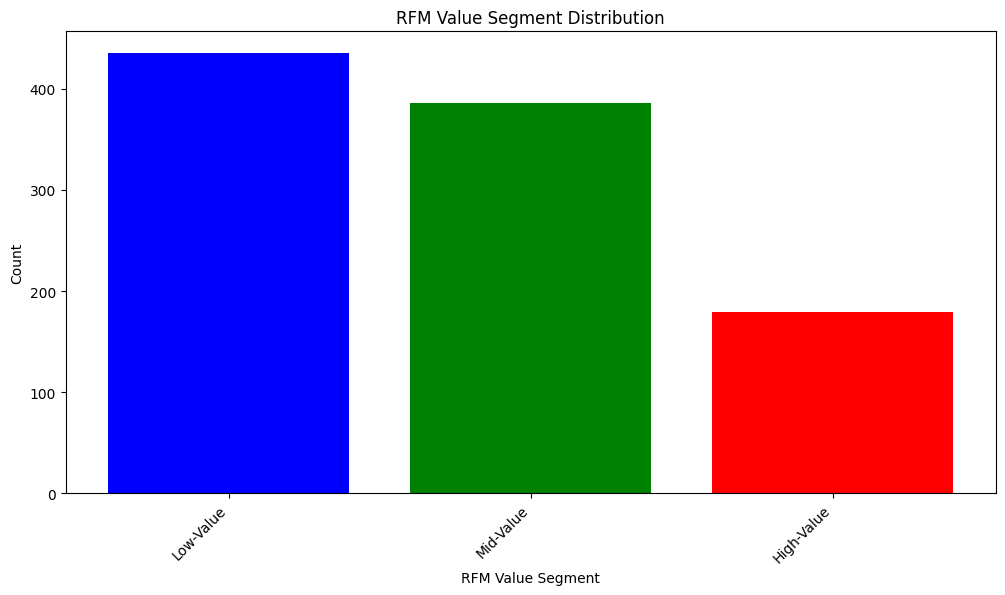

In [8]:
x = segment_counts['Value Segment']
y = segment_counts['Count']
colors = ['blue', 'green', 'red']
plt.figure(figsize=(12, 6))
plt.bar(x, y, color = colors)
plt.title('RFM Value Segment Distribution')
plt.xlabel('RFM Value Segment')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
bar = plt.show()
bar

In [9]:
# Create a new column for RFM Customer Segments
data['RFM Customer Segments'] = ''

# Assign RFM segments based on the RFM score
data.loc[data['RFM_Score'] >= 9, 'RFM Customer Segments'] = 'Champions'
data.loc[(data['RFM_Score'] >= 6) & (data['RFM_Score'] < 9), 'RFM Customer Segments'] = 'Potential Loyalists'
data.loc[(data['RFM_Score'] >= 5) & (data['RFM_Score'] < 6), 'RFM Customer Segments'] = 'At Risk Customers'
data.loc[(data['RFM_Score'] >= 4) & (data['RFM_Score'] < 5), 'RFM Customer Segments'] = "Can't Lose"
data.loc[(data['RFM_Score'] >= 3) & (data['RFM_Score'] < 4), 'RFM Customer Segments'] = "Lost"

segment_product_counts = data.groupby(['Value Segment', 'RFM Customer Segments']).size().reset_index(name='Count')

segment_product_counts = segment_product_counts.sort_values('Count', ascending=False)

C:\Users\Jeevan kishore\AppData\Local\Temp\ipykernel_13700\2835795697.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_product_counts = data.groupby(['Value Segment', 'RFM Customer Segments']).size().reset_index(name='Count')


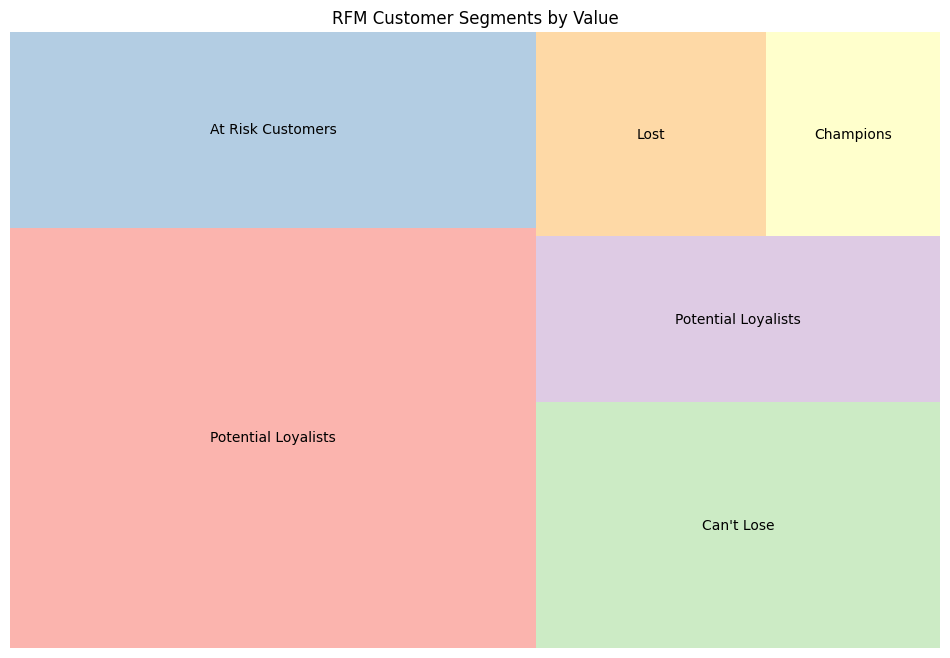

In [10]:
# Filter out rows with zero or very small 'Count'
segment_product_counts = segment_product_counts[segment_product_counts['Count'] > 0]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the treemap
squarify.plot(sizes=segment_product_counts['Count'], label=segment_product_counts['RFM Customer Segments'], color=plt.cm.Pastel1.colors, ax=ax)

# Add labels and title
plt.title('RFM Customer Segments by Value')
plt.axis('off')  # Turn off axis labels

tree = plt.show()
tree


In [11]:
# Filter the data to include only the customers in the Champions segment
champions_segment = data[data['RFM Customer Segments'] == 'Champions']

champions_segment_fig = go.Figure()
champions_segment_fig.add_trace(go.Box(y=champions_segment['RecencyScore'], name='Recency'))
champions_segment_fig.add_trace(go.Box(y=champions_segment['FrequencyScore'], name='Frequency'))
champions_segment_fig.add_trace(go.Box(y=champions_segment['MonetaryScore'], name='Monetary'))

champions_segment_fig.update_layout(title='Distribution of RFM Values within Champions Segment',
                  yaxis_title='RFM Value',
                  showlegend=True)

box = champions_segment_fig.show()
box

correlation_matrix = champions_segment[['RecencyScore', 'FrequencyScore', 'MonetaryScore']].corr()

In [12]:
# Visualize the correlation matrix using a heatmap
fig_corr_heatmap = go.Figure(data=go.Heatmap(
                   z=correlation_matrix.values,
                   x=correlation_matrix.columns,
                   y=correlation_matrix.columns,
                   colorscale='RdBu',
                   colorbar=dict(title='Correlation')))

fig_corr_heatmap.update_layout(title='Correlation Matrix of RFM Values within Champions Segment')

heatmap = fig_corr_heatmap.show()
heatmap

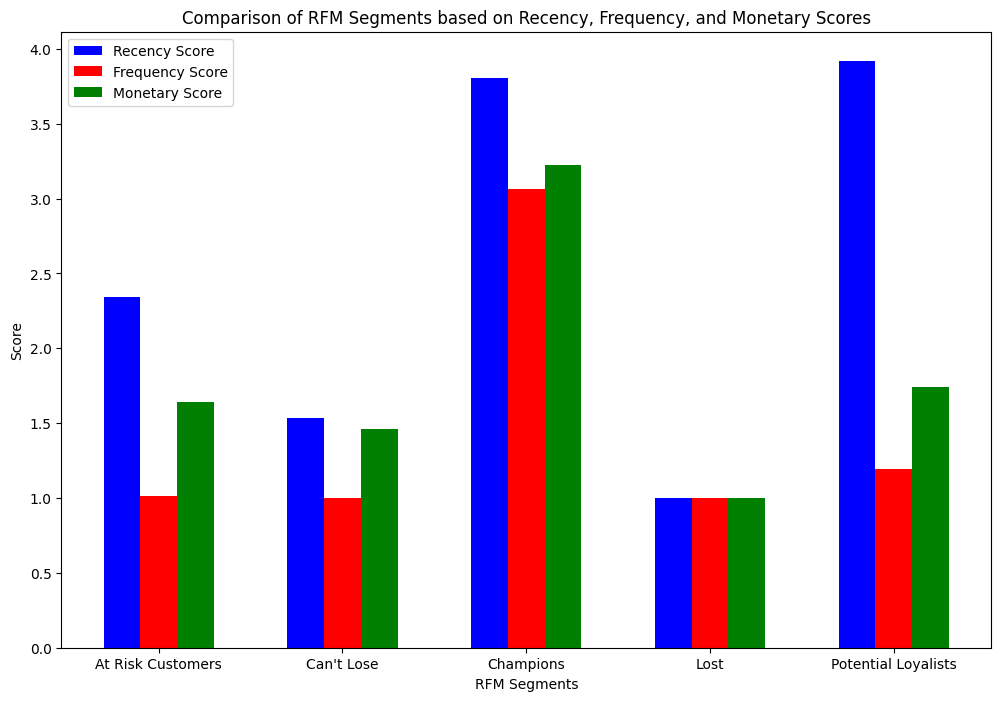

In [20]:
# Calculate the average Recency, Frequency, and Monetary scores for each segment
segment_scores = data.groupby('RFM Customer Segments')[['RecencyScore', 'FrequencyScore', 'MonetaryScore']].mean().reset_index()

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Bar width
bar_width = 0.2

# X-axis positions for the bars
positions = np.arange(len(segment_scores['RFM Customer Segments']))

# Plot bars for Recency score
ax.bar(positions - bar_width, segment_scores['RecencyScore'], bar_width, label='Recency Score', color='blue')

# Plot bars for Frequency score
ax.bar(positions, segment_scores['FrequencyScore'], bar_width, label='Frequency Score', color='red')

# Plot bars for Monetary score
ax.bar(positions + bar_width, segment_scores['MonetaryScore'], bar_width, label='Monetary Score', color='green')

# Add labels and title
ax.set_title('Comparison of RFM Segments based on Recency, Frequency, and Monetary Scores')
ax.set_xlabel('RFM Segments')
ax.set_ylabel('Score')
ax.set_xticks(positions)
ax.set_xticklabels(segment_scores['RFM Customer Segments'])
ax.legend()

Comparison_of_RFM_Segments = plt.show()
Comparison_of_RFM_Segments


In [21]:
# Initialize the Dash app
app = dash.Dash(__name__)

# Define the app layout using Bootstrap components
app.layout = html.Div([
    html.H1("RFM Analysis Dashboard", className="text-center mb-4"),
    html.Div("Analyze customer segments based on RFM scores.", className="text-center mb-4"),
    
    # Dropdown for selecting the chart
    dcc.Dropdown(
        id='chart-type-dropdown',
        options=[
            {'label': 'RFM Value Segment Distribution', 'value': 'segment_distribution'},
            {'label': 'Distribution of RFM Values within Customer Segment', 'value': 'RFM_distribution'},
            {'label': 'Correlation Matrix of RFM Values within Champions Segment', 'value': 'correlation_matrix'},
            {'label': 'Comparison of RFM Segments', 'value': 'segment_comparison'},
            {'label': 'Comparison of RFM Segments based on Scores', 'value': 'segment_scores'},
        ],
        value='segment_distribution',  # Default selection
        className="mb-4",
    ),
    
    # Graph container
    dcc.Graph(id='rfm-chart', className="mb-4"),
])

# Define callback to update the selected chart
@app.callback(
    Output('rfm-chart', 'figure'),
    [Input('chart-type-dropdown', 'value')]
)
def update_chart(selected_chart_type):
    if selected_chart_type == 'segment_distribution':
        return bar
    elif selected_chart_type == 'RFM_distribution':
        return tree
    elif selected_chart_type == 'correlation_matrix':
        return heatmap
    elif selected_chart_type == 'segment_scores':
        return Comparison_of_RFM_Segments
    
    # Return a default chart if no valid selection
    return bar

if __name__ == '__main__':
    app.run_server(port=8052)